In [72]:
import pandas as pd
import numpy as np

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median
from sklearn.utils import resample

# ALGOS
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import xgboost as xgb


from sklearn import metrics
from sklearn.utils import resample
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

import itertools

import warnings

warnings.filterwarnings('ignore')

In [2]:
modelling_df = pd.read_csv('../data/sinave4.csv')

In [3]:
modelling_df.shape

(341990, 74)

In [4]:
# modelling_df.info()

In [5]:
modelling_df['estado'].value_counts(normalize = True)

ACTIVOS LEVES     0.474917
RECUPERADOS       0.451844
FALLECIDOS        0.057241
ACTIVOS GRAVES    0.015998
Name: estado, dtype: float64

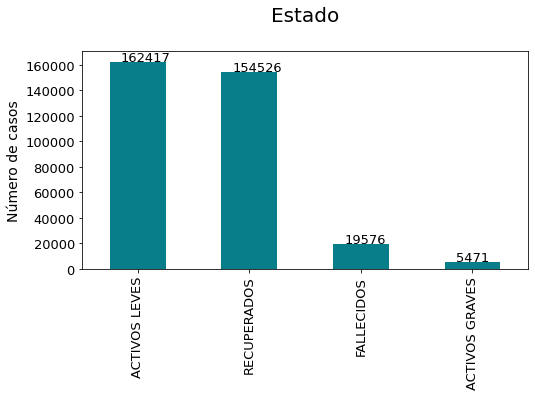

In [6]:
ax = modelling_df['estado'].value_counts().plot(kind='bar', figsize=(8, 4), fontsize=13, color='#087E8B')
ax.set_title('Estado', size=20, pad=30)
ax.set_ylabel('Número de casos', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.10, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=13)

In [7]:
modelling_df3_2cat = modelling_df.copy()

In [8]:
modelling_df3_2cat['estado'].replace(to_replace=['ACTIVOS LEVES', 'RECUPERADOS', 'FALLECIDOS', 'ACTIVOS GRAVES'],value=['RECUPERADOS','RECUPERADOS','FALLECIDOS','FALLECIDOS'],inplace=True)

In [9]:
# modelling_df3_2cat = modelling_df3_2cat[modelling_df3_2cat["estado"].isin(['RECUPERADOS','FALLECIDOS'])]

In [10]:
modelling_df3_2cat.estado.unique()

array(['RECUPERADOS', 'FALLECIDOS'], dtype=object)

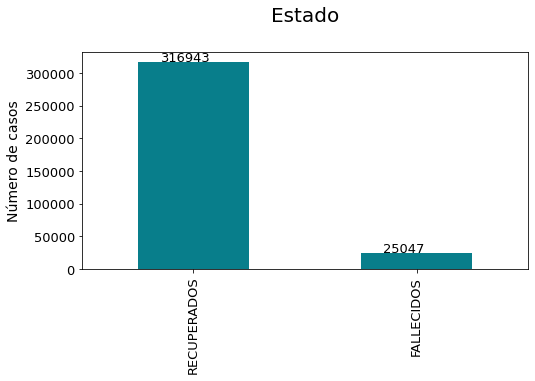

In [11]:
ax = modelling_df3_2cat['estado'].value_counts().plot(kind='bar', figsize=(8, 4), fontsize=13, color='#087E8B')
ax.set_title('Estado', size=20, pad=30)
ax.set_ylabel('Número de casos', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.10, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=13)

In [12]:
# Convert to dummies
modelling_df3_2cat['estado'].replace(to_replace=['RECUPERADOS', 'FALLECIDOS'], 
                                     value=[0,1],inplace=True)

In [13]:
modelling_df3_2cat_test = modelling_df3_2cat.sample(n=20,random_state=200) #random state is a seed value
modelling_df4_2cat = modelling_df3_2cat.drop(modelling_df3_2cat_test.index)

In [14]:
modelling_df3_2cat_test.shape

(20, 74)

In [15]:
modelling_df4_2cat['estado'].value_counts()

0    316925
1     25045
Name: estado, dtype: int64

# SEMIBALANCED BICLASS

In [16]:
# sm = SMOTE(random_state = 42)

In [17]:
# X, y = sm.fit_resample(X, y)

### RESAMPLE

In [18]:
features = ['fiebre', 'tos','odinofagia','disnea','irritabilidad','diarrea','dolor_toracico','calofrios', 'cefalea','mialgias','artralgias','ataque_al_estado_general','rinorrea','polipnea','vomito','dolor_abdominal','conjuntivitis','cianosis','diabetes', 'epoc', 'asma', 'inmunosupresivo','hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca','obesidad', 'insuficiencia_renal_cronica', 'tabaquismo', 'diabetes', 'epoc', 'asma', 'inmunosupresivo',
       'hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca',
       'obesidad', 'insuficiencia_renal_cronica', 'tabaquismo']

In [19]:
X = modelling_df4_2cat[features].copy()
y = modelling_df4_2cat['estado'].copy()

In [20]:
X = np.array(X)

In [22]:
count_class_0 = 60090
count_class_1 = 25045
pipe = make_pipeline(SMOTE(sampling_strategy={1: count_class_1}), NearMiss(sampling_strategy={0: count_class_0}))

X, y = pipe.fit_resample(X, y)

In [23]:
from collections import Counter
counter = Counter(y)

for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=60090 (70.582%)
Class=1, n=25045 (29.418%)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (68108, 40) (68108,)
Test set: (17027, 40) (17027,)


In [26]:
# estandarizamos los datos

ss = preprocessing.StandardScaler().fit(X_train.astype(np.float))
X_train = ss.transform(X_train.astype(np.float))
X_test = ss.transform(X_test.astype(np.float))

## Logistic Regression Classifier

In [27]:
# Confusion Matrix plotting function
# https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [29]:
# Encuentra los mejores hiperparámetros para logistic regression classifier
#Logistic Regression soporta solo solvers en ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
results_df = pd.DataFrame(index=cs)
results_df.index.name='C'
for s in solvers:
    results = []
    for c in cs:
        LR = LogisticRegression(C=c, solver=s, max_iter=4000, random_state=42).fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        j_score = jaccard_score(y_test, y_pred)
        results.append(j_score)
    results_df[s] = results
results_df

,newton-cg,lbfgs,liblinear,sag,saga
C,,,,,
0.0001,0.578180,0.578180,0.643233,0.578180,0.578180
0.0010,0.619764,0.619764,0.631490,0.619764,0.619764
0.0100,0.625042,0.625042,0.625762,0.625042,0.625042
0.1000,0.624260,0.624091,0.624429,0.624260,0.624260
1.0000,0.624429,0.624429,0.624429,0.624429,0.624429
10.0000,0.624429,0.624429,0.624429,0.624429,0.624429
100.0000,0.624429,0.624429,0.624429,0.624429,0.624429


Confusion matrix, without normalization


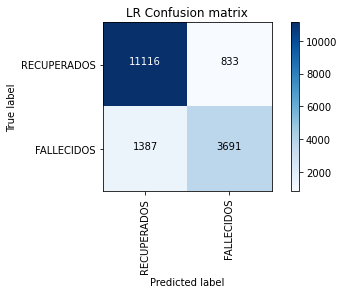

In [30]:
import itertools


# Ejecutamos logistic regression classifier y mostramos resultados

LR = LogisticRegression(C=10.0000, solver='newton-cg', random_state=42).fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)


LR_j_score = jaccard_score(y_test, y_pred)
LR_j_score_train = jaccard_score(y_train, y_pred_train)

LR_f_score = f1_score(y_test, y_pred, average='weighted')
LR_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

LR_class_report = classification_report(y_test, y_pred)
LR_class_report_train = classification_report(y_train, y_pred_train)

LR_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS', 'FALLECIDOS'],normalize=False,  title='LR Confusion matrix')

In [32]:
print('Logistic Regression train jaccard score:', round(LR_j_score_train, 4))
print('Logistic Regression test jaccard score:', round(LR_j_score, 4))

print('\nLogistic Regression TRAIN classification report:\n\n', LR_class_report_train)
print('Logistic Regression TEST classification report:\n\n', LR_class_report)

Logistic Regression train jaccard score: 0.6181
Logistic Regression test jaccard score: 0.6244

Logistic Regression TRAIN classification report:

               precision    recall  f1-score   support

           0       0.89      0.93      0.91     48141
           1       0.81      0.72      0.76     19967

    accuracy                           0.87     68108
   macro avg       0.85      0.83      0.84     68108
weighted avg       0.87      0.87      0.87     68108

Logistic Regression TEST classification report:

               precision    recall  f1-score   support

           0       0.89      0.93      0.91     11949
           1       0.82      0.73      0.77      5078

    accuracy                           0.87     17027
   macro avg       0.85      0.83      0.84     17027
weighted avg       0.87      0.87      0.87     17027



## Decision Tree Classifier

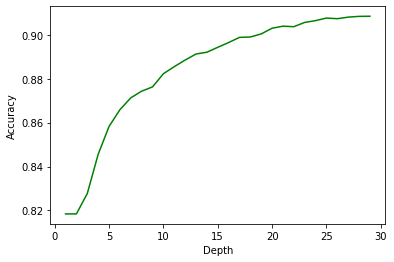

The best accuracy is 0.9084 with depth= 29


In [33]:
depth = 30 #30
mean_acc = np.zeros((depth-1))
for n in range(1,depth): 
    DT = DecisionTreeClassifier(criterion="entropy", max_depth = n, random_state=42).fit(X_train,y_train)
    y_pred=DT.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
plt.plot(range(1,depth),mean_acc,'g')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()
print("The best accuracy is", round(mean_acc.max(), 4), "with depth=", mean_acc.argmax()+1)

Confusion matrix, without normalization


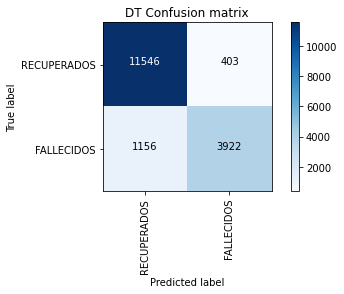

In [35]:
# rejecuta el decision tree classifier y muestra los resultados

DT = DecisionTreeClassifier(criterion="entropy", max_depth = 29, random_state=42).fit(X_train, y_train)
y_pred = DT.predict(X_test)
y_pred_train = DT.predict(X_train)


DT_j_score = jaccard_score(y_test, y_pred)
DT_j_score_train = jaccard_score(y_train, y_pred_train)

DT_f_score = f1_score(y_test, y_pred, average='weighted')
DT_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

DT_class_report = classification_report(y_test, y_pred)
DT_class_report_train = classification_report(y_train, y_pred_train)

DT_dict = classification_report(y_test, y_pred, output_dict=True)
DT_dict_train = classification_report(y_train, y_pred_train, output_dict=True)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='DT Confusion matrix')

In [36]:
print('Decision Tree TRAIN jaccard score:', round(DT_j_score_train, 2),
      '\nDecision Tree TEST jaccard score:', round(DT_j_score, 2))

print('\nDecision Tree TRAIN classification report:\n\n', DT_class_report_train)
print('\nDecision Tree TEST classification report:\n\n', DT_class_report)

Decision Tree TRAIN jaccard score: 0.76 
Decision Tree TEST jaccard score: 0.72

Decision Tree TRAIN classification report:

               precision    recall  f1-score   support

           0       0.92      0.97      0.95     48141
           1       0.92      0.81      0.86     19967

    accuracy                           0.92     68108
   macro avg       0.92      0.89      0.91     68108
weighted avg       0.92      0.92      0.92     68108


Decision Tree TEST classification report:

               precision    recall  f1-score   support

           0       0.91      0.97      0.94     11949
           1       0.91      0.77      0.83      5078

    accuracy                           0.91     17027
   macro avg       0.91      0.87      0.89     17027
weighted avg       0.91      0.91      0.91     17027



## Random Forest Classifier

In [ ]:
# n_estimators = [100, 300, 500, 800]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# gs = GridSearchCV(
#     estimator = RandomForestClassifier(), 
#     param_grid = {
#           "n_estimators" : n_estimators,
#           "max_depth" : max_depth,
#           "min_samples_split" : min_samples_split,
#           "min_samples_leaf" : min_samples_leaf,
#           },
#           cv=5,
#           verbose=3,
#           scoring = "neg_root_mean_squared_error",
#           return_train_score = True
# )

In [ ]:

# %%time
# gs.fit(X_train, y_train)

In [ ]:
# grid_search_results = pd.DataFrame(gs.cv_results_)

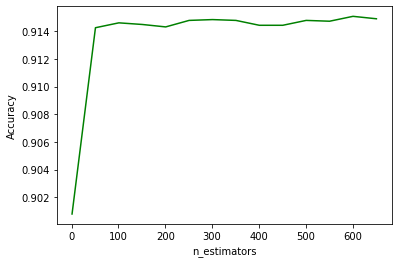

The best accuracy is 0.9151 with n_estimators= 601


In [37]:
depth = 700
mean_acc = np.zeros((depth-1))
for n in range(1,depth,50): 
    RF = RandomForestClassifier(n_estimators = n, random_state = 42).fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
plt.plot(range(1,depth,50),mean_acc[::50],'g')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()
print( "The best accuracy is", round(mean_acc.max(), 4), "with n_estimators=", mean_acc.argmax()+1)

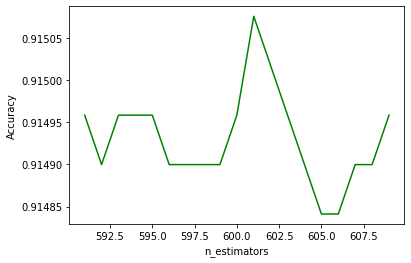

The best accuracy is 0.9151 with n_estimators= 601


In [39]:
depth = 610
mean_acc = np.zeros((depth-1))
# for n in range(1,depth,501): 
for n in range(590,depth): 
    RF = RandomForestClassifier(n_estimators=n, random_state=42).fit(X_train,y_train)
    yhat=RF.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
# plt.plot(range(1,depth,501),mean_acc[::501],'g')
plt.plot(range(591,depth),mean_acc[590:610],'g')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()
print( "The best accuracy is", round(mean_acc.max(), 4), "with n_estimators=", mean_acc.argmax()+1)


Confusion matrix, without normalization


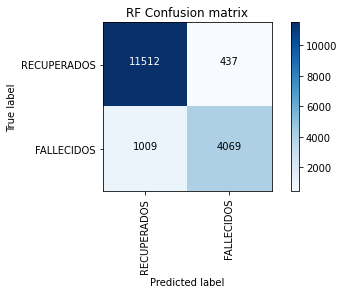

In [41]:
# ejecutar random forest y mostrar resultados

RF = RandomForestClassifier(n_estimators=601, random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_pre_train = RF.predict(X_train)


RF_j_score = jaccard_score(y_test, y_pred)
RF_j_score_train = jaccard_score(y_train, y_pred_train)


RF_f_score = f1_score(y_test, yhat, average='weighted')
RF_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

RF_class_report = classification_report(y_test, y_pred)
RF_class_report_train = classification_report(y_train, y_pred_train)


RF_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='RF Confusion matrix')

In [42]:
print('Random Forest Classifier TRAIN jaccard score:', round(RF_j_score_train, 2),
      '\nRandom Forest Classifier TEST jaccard score:', round(RF_j_score, 2))

print('\nRandom Forest Classifier TRAIN classification report:\n\n', RF_class_report_train)
print('\nRandom Forest Classifier TEST classification report:\n\n', RF_class_report)

Random Forest Classifier TRAIN jaccard score: 0.76 
Random Forest Classifier TEST jaccard score: 0.74

Random Forest Classifier TRAIN classification report:

               precision    recall  f1-score   support

           0       0.92      0.97      0.95     48141
           1       0.92      0.81      0.86     19967

    accuracy                           0.92     68108
   macro avg       0.92      0.89      0.91     68108
weighted avg       0.92      0.92      0.92     68108


Random Forest Classifier TEST classification report:

               precision    recall  f1-score   support

           0       0.92      0.96      0.94     11949
           1       0.90      0.80      0.85      5078

    accuracy                           0.92     17027
   macro avg       0.91      0.88      0.90     17027
weighted avg       0.91      0.92      0.91     17027



## K-Nearest Neighbors (KNN) Classifier

In [43]:
# encontrar los mejores hiperparámetros para K-Nearest Neighbors (KNN) Classifier, solo k impar

Ks = 38 #38
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    KNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_pred= KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    
    std_acc[n-1] = np.std(y_pred == y_test)/np.sqrt(y_pred.shape[0])

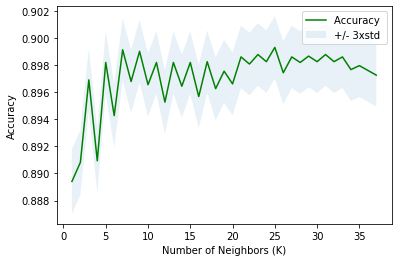

The best accuracy was with 0.8993 with k= 25


In [44]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))

plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.show()
print("The best accuracy was with", round(mean_acc.max(), 4), "with k=", mean_acc.argmax()+1)

Confusion matrix, without normalization


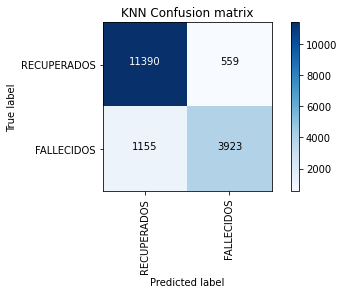

In [45]:
# ejecutar K-Nearest Neighbors (KNN) Classifier y mostrar resultados

KNN = KNeighborsClassifier(n_neighbors = 25).fit(X_train,y_train)
y_pred = KNN.predict(X_test)
y_pred_train = KNN.predict(X_train)


KNN_j_score = jaccard_score(y_test, y_pred)
KNN_j_score_train = jaccard_score(y_train, y_pred_train)


KNN_f_score = f1_score(y_test, y_pred, average='weighted')
KNN_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

KNN_class_report = classification_report(y_test, y_pred)
KNN_class_report_train = classification_report(y_train, y_pred_train)

KNN_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='KNN Confusion matrix')

In [46]:
print('KNN jaccard train score:', round(KNN_j_score_train, 4))
print('KNN jaccard test score:', round(KNN_j_score, 4))

print('\nKNN train classification report:\n\n', KNN_class_report_train)
print('KNN test classification report:\n\n', KNN_class_report)

KNN jaccard train score: 0.7056
KNN jaccard test score: 0.6959

KNN train classification report:

               precision    recall  f1-score   support

           0       0.91      0.96      0.93     48141
           1       0.88      0.78      0.83     19967

    accuracy                           0.90     68108
   macro avg       0.90      0.87      0.88     68108
weighted avg       0.90      0.90      0.90     68108

KNN test classification report:

               precision    recall  f1-score   support

           0       0.91      0.95      0.93     11949
           1       0.88      0.77      0.82      5078

    accuracy                           0.90     17027
   macro avg       0.89      0.86      0.88     17027
weighted avg       0.90      0.90      0.90     17027



## Naive Bayes Classifier

Confusion matrix, without normalization


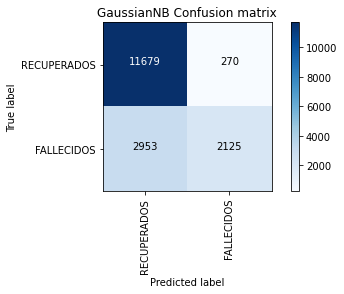

In [48]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)


gnb_j_score = jaccard_score(y_test, y_pred)
gnb_j_score_train = jaccard_score(y_train, y_pred_train)


gnb_f_score = f1_score(y_test, yhat, average='weighted')
gnb_f_score_train = f1_score(y_train, y_pred_train, average='weighted')


gnb_class_report = classification_report(y_test, y_pred)
gnb_class_report_train = classification_report(y_train, y_pred_train)


gnb_dict = classification_report(y_test, y_pred, output_dict=True)
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='GaussianNB Confusion matrix')

In [49]:
print('RF jaccard test score:', round(gnb_j_score, 4))
print('RF jaccard train score:', round(gnb_j_score_train, 4))

print('\nRF classification test report:\n\n', gnb_class_report)
print('RF classification train report:\n\n', gnb_class_report_train)

RF jaccard test score: 0.3973
RF jaccard train score: 0.3903

RF classification test report:

               precision    recall  f1-score   support

           0       0.80      0.98      0.88     11949
           1       0.89      0.42      0.57      5078

    accuracy                           0.81     17027
   macro avg       0.84      0.70      0.72     17027
weighted avg       0.82      0.81      0.79     17027

RF classification train report:

               precision    recall  f1-score   support

           0       0.80      0.98      0.88     48141
           1       0.89      0.41      0.56     19967

    accuracy                           0.81     68108
   macro avg       0.85      0.69      0.72     68108
weighted avg       0.83      0.81      0.79     68108



## Support Vector Machine (SVM) Classifier

In [71]:
# SVM no funciona bien con conjuntos de datos grandes, por lo que solo usé el kernel 'rbf'

SVM = svm.SVC(kernel='rbf', gamma='auto', random_state=42, probability=True).fit(X_train, y_train)

y_pred = SVM.predict(X_test)
y_pred_train = SVM.predict(X_train)

SVM_j_score = jaccard_score(y_test, y_pred)
SVM_j_score_train = jaccard_score(y_train, y_pred_train)

SVM_f_score = f1_score(y_test, y_pred, average='weighted')
SVM_f_score_train = f1_score(y_train, y_pred_train, average='weighted')


SVM_class_report = classification_report(y_test, y_pred)
SVM_class_report_train = classification_report(y_train, y_pred_train)


SVM_dict = classification_report(y_test, y_pred, output_dict=True)
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='SVM Confusion matrix')

KeyboardInterrupt: 

In [51]:
print('SVM jaccard test score:', round(SVM_j_score, 4))
print('SVM jaccard train score:', round(SVM_j_score_train, 4))

print('\nSVM classification test report:\n\n', SVM_class_report)
print('SVM classification train report:\n\n', SVM_class_report_train)

SVM jaccard test score: 0.7159
SVM jaccard train score: 0.718

SVM classification test report:

               precision    recall  f1-score   support

           0       0.91      0.96      0.94     11949
           1       0.89      0.79      0.83      5078

    accuracy                           0.91     17027
   macro avg       0.90      0.87      0.88     17027
weighted avg       0.91      0.91      0.91     17027

SVM classification train report:

               precision    recall  f1-score   support

           0       0.92      0.96      0.94     48141
           1       0.89      0.79      0.84     19967

    accuracy                           0.91     68108
   macro avg       0.90      0.87      0.89     68108
weighted avg       0.91      0.91      0.91     68108



## XGboost Classifier

In [73]:
xg_class = xgb.XGBClassifier()
xg_class.fit(X_train, y_train)

[15:23:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Confusion matrix, without normalization


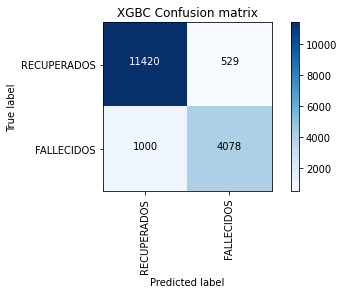

In [74]:
y_pred = xg_class.predict(X_test)
y_pred_train = xg_class.predict(X_train)

xg_class_j_score = jaccard_score(y_test, y_pred)
xg_class_j_score_train = jaccard_score(y_train, y_pred_train)

xg_class_f_score = f1_score(y_test, y_pred, average='weighted')
xg_class_f_score_train = f1_score(y_train, y_pred_train, average='weighted')


xg_class_class_report = classification_report(y_test, y_pred)
xg_class_class_report_train = classification_report(y_train, y_pred_train)


xg_class_dict = classification_report(y_test, y_pred, output_dict=True)
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='XGBC Confusion matrix')

In [75]:
print('XGBC jaccard test score:', round(xg_class_j_score, 4))
print('XGBC jaccard train score:', round(xg_class_j_score_train, 4))

print('\nXGBC classification test report:\n\n', xg_class_class_report)
print('XGBC classification train report:\n\n', xg_class_class_report_train)

XGBC jaccard test score: 0.7273
XGBC jaccard train score: 0.7319

XGBC classification test report:

               precision    recall  f1-score   support

           0       0.92      0.96      0.94     11949
           1       0.89      0.80      0.84      5078

    accuracy                           0.91     17027
   macro avg       0.90      0.88      0.89     17027
weighted avg       0.91      0.91      0.91     17027

XGBC classification train report:

               precision    recall  f1-score   support

           0       0.92      0.96      0.94     48141
           1       0.89      0.81      0.85     19967

    accuracy                           0.91     68108
   macro avg       0.91      0.88      0.89     68108
weighted avg       0.91      0.91      0.91     68108



In [76]:
# get results from all the classifiers to compare

J_results = {'Logistic Regression':round(LR_j_score, 4),
             'Decision Tree':round(DT_j_score, 4),
             'Random Forest':round(RF_j_score, 4),
             'K-Nearest Neighbors':round(KNN_j_score, 4),             
             'Naive Bayes':round(gnb_j_score,4),
             'Support Vector Machine':round(SVM_j_score, 4),
             'XGBC classification':round(xg_class_f_score, 4)}

F_results = {'Logistic Regression':round(LR_f_score, 4),
             'Decision Tree':round(DT_f_score, 4),
             'Random Forest':round(RF_f_score, 4),
             'K-Nearest Neighbors':round(KNN_f_score, 4),             
             'Naive Bayes':round(gnb_f_score,4),
             'Support Vector Machine':round(SVM_f_score, 4),
             'XGBC classification':round(xg_class_f_score, 4),
             'Support Vector Machine':round(SVM_f_score, 4)}

Class_F1_results = {'Logistic Regression':round(LR_dict['0']['f1-score'], 4),
                    'Decision Tree':round(DT_dict['0']['f1-score'], 4),
                    'Random Forest':round(RF_dict['0']['f1-score'], 4),
                    'Naive Bayes':round(gnb_dict['0']['f1-score'],4),
                    'K-Nearest Neighbors':round(KNN_dict['0']['f1-score'], 4),
                    'Support Vector Machine':round(SVM_dict['0']['f1-score'], 4),
                    'XGBC classification':round(xg_class_dict['0']['f1-score'], 4)}


Class_Recall_results = {'Logistic Regression':round(LR_dict['0']['recall'], 4),
                        'Decision Tree':round(DT_dict['0']['recall'], 4),
                        'Random Forest':round(RF_dict['0']['recall'], 4),
                        'Naive Bayes':round(gnb_dict['0']['recall'],4),
                        'K-Nearest Neighbors':round(KNN_dict['0']['recall'], 4),
                        'Support Vector Machine':round(SVM_dict['0']['recall'], 4),
                        'XGBC classification':round(xg_class_dict['0']['recall'], 4)}

In [77]:
final_results = pd.DataFrame([J_results,F_results,Class_F1_results,Class_Recall_results],
                        index=['Jaccard Score','F1 Score','Fallecido Class F1 Score','Fallecido Class Recall Score'])
final_results

,Logistic Regression,Decision Tree,Random Forest,K-Nearest Neighbors,Naive Bayes,Support Vector Machine,XGBC classification
Jaccard Score,0.6244,0.7156,0.7378,0.6959,0.3973,0.7159,0.9089
F1 Score,0.8673,0.9062,0.9134,0.8974,0.9134,0.9050,0.9089
Fallecido Class F1 Score,0.9092,0.9368,0.9409,0.9300,0.8787,0.9350,0.9373
Fallecido Class Recall Score,0.9303,0.9663,0.9634,0.9532,0.9774,0.9568,0.9557


In [ ]:
# Define the models you want to use
models = [
 {'label': 'Logistic Regression', 'model': LogisticRegression(C=0.1, solver='newton-cg', random_state=42)},
    {'label': 'Naive Bayes', 'model': GaussianNB()},
    {'label': 'Decision Tree', 'model': DecisionTreeClassifier(criterion="entropy", max_depth = 7, random_state=42)},
    {'label': 'KNN', 'model': KNeighborsClassifier(n_neighbors = 31)},
    {'label': 'Random Forest', 'model': RandomForestClassifier(n_estimators=590, random_state=42)},
    {'label': 'SVM', 'model': svm.SVC(kernel='rbf', gamma='auto', random_state=42, probability=True)}
]

# Define the size of the figure
plt.figure(figsize = [11,9])


for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])  
    auc = metrics.roc_auc_score(y_test,model.predict(X_test)) 
    plt.plot(fpr, tpr, label ='%s ROC (area = %0.2f)' % (m['label'], auc)) 
        
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()